# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Procesamiento de Lenguaje Natural (NLP)**
### Tecnológico de Monterrey
### Prof Luis Eduardo Falcón Morales

### **Nombres y matrículas de los integrantes del equipo:**
* Diego Alonso Luna Ramirez  - A01793035
* Jessica Lechuga Ramos - A01793512
* José Javier Granados Hernández - A0056717
* Jorge Fernández Lara - A01793062
* Kevin Brandon Cruz Mejía -A01794176
## **Adtividad de la Semana 06 y 07**
### **Modelado de Temas.**

En la actividad de esta semana trabajarás en equipos en el tema de modelado de temas (topic modeling).

Descarga el archivo noticiasTopicModeling.txt que se encuentra en Canvas. Este archivo consiste en 5658 noticias de varios periódicos de España. El archivo de texto es una lista en el siguiente formato: [{“titular”:”Encabezado“, “texto”:”Cuerpo”}, … , {“titular”:”Encabezado”,”texto”:”Cuerpo”}] Donde “titular” es el encabezado de la noticia y “texto” es el cuerpo del texto de dicha noticia. En particular en esta actividad trabajarás solamente con los cuerpos de las noticias, sin incluir los encabezados. Carga dicho archivo y genera un DataFrame de Pandas llamado “df” y que contiene una única columna llamada “noticia” con 5658 renglones formados por los cuerpos de las noticias.

In [ ]:
#!pip install nltk
#!pip install spacy
#!python -m spacy download es_core_news_sm
#!pip install pyLDAvis
#!pip install gensim

In [ ]:
#Librerías
import ast
import matplotlib.pyplot as plt
import pandas as pd
import pyLDAvis.gensim_models
import requests
import re
import spacy
import nltk

from gensim import models
from gensim import corpora
from gensim.models import LdaModel
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

my_stopwords = stopwords.words('spanish')
nlp = spacy.load("es_core_news_sm")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mapc1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mapc1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mapc1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# URL del archivo en GitHub
url = 'https://raw.githubusercontent.com/jorgefdzlara/NLP_EQ17/main/data/noticiasTopicModeling.txt'

# Realizar la solicitud HTTP y obtener el contenido del archivo
response = requests.get(url)
data = response.text

# Convertir el contenido del archivo en una lista de diccionarios
data = ast.literal_eval(data)

# Extraer los textos de cada noticia
new_data = [x['texto'] for x in data]

# Crear el DataFrame de Pandas
df = pd.DataFrame(data=new_data, columns=['noticia'])


In [ ]:
print(df)

                                                noticia
0     "España ha dejado de ser católica", decía Manu...
1     El clima de crispación social en Ceuta ha lleg...
2     El Gobierno ha alegado la suspensión de plazos...
3     Puedes mandar tu pregunta, sugerencia o queja ...
4     Panamá debe entregar esta semana a la Corte In...
...                                                 ...
5653  El juez del caso Villarejo, Manuel García-Cast...
5654  España se acerca a los 260.000 casos de COVID-...
5655  Transferencias, préstamos y condiciones. "Nunc...
5656  El 14 de marzo, ante la declaración del estado...
5657  Madrid, 1 sep (EFE).- Finalmente, septiembre h...

[5658 rows x 1 columns]


2. Realiza un proceso de limpieza. Aplica el preprocesamiento que consideres adecuado para texto en 
español. Recuerda que el objetivo es identificar los tokens que describan mejor la distribución de 
cada tema. 

In [ ]:
# Definir la función de preprocesamiento
def preprocess(text):
    tokens = []

    # Eliminar caracteres no deseados
    text = re.sub(r'[^A-Za-zá-úñÑ]', ' ', text)   # Solo consideramos caracteres letras, observa que lo extendemos al español.
    text = re.sub(r'\s{2,}', ' ', text.strip())      # Eliminemos espacios en blanco extras entre palabras o al inicio o final de cada frase.
    
    words = nlp(text)
    word_size = 2

    #Stopwords y palabras con longitud mayor a 1
    for word in words:
        new_word = str(word.lemma_.lower()).split(" ")[0]
        if not new_word in my_stopwords and len(new_word) > word_size:
            tokens.append(new_word)

    return ' '.join(tokens)

# Aplicar preprocesamiento a la columna 'noticia' del DataFrame
df['phrases'] = df['noticia'].apply(preprocess)


3. ¿Por qué en este caso no requerimos hacer una partición en entrenamiento, validación y prueba?

En este caso, no requerimos hacer una partición en entrenamiento, validación y prueba porque el objetivo principal de esta actividad es realizar el proceso de modelado de temas (topic modeling) sobre el conjunto completo de noticias. No estamos desarrollando un modelo predictivo o de clasificación en el que necesitemos evaluar su rendimiento en conjuntos de datos separados.

El modelado de temas se basa en el análisis y la identificación de patrones y estructuras latentes dentro de un corpus de texto. El objetivo es descubrir los temas o tópicos subyacentes en el conjunto de noticias y analizar cómo se distribuyen las palabras y los documentos en relación con estos temas.

Por lo tanto, en este caso, el enfoque es aplicar técnicas de procesamiento de texto y modelado de temas directamente sobre el conjunto completo de noticias para extraer información significativa y comprender la estructura de los temas presentes en el corpus. No es necesario dividir el conjunto de datos en diferentes conjuntos debido a que no estamos construyendo un modelo predictivo que requiera evaluación en datos independientes (modelo supervisado).

## Parte 1: Indexación semántica latente (LSI): 

4. Encontrar la matriz Tf-idf de la columna de noticias. Despliega los primeros 5 renglones con algunas de sus columnas con sus nombres, donde las columnas son los tokens. ¿Cuál es el significado de cada renglón? ¿Y el significado de cada columna?

In [ ]:
# Crear el objeto TfidfVectorizer
vectorizer = TfidfVectorizer()

# Aplicar el vectorizador a la columna de noticias
tfidf_matrix = vectorizer.fit_transform(df['phrases'])

# Obtener los nombres de las características (tokens)
feature_names = vectorizer.vocabulary_.keys()

# Crear un DataFrame de Pandas con la matriz Tf-idf
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Mostrar los primeros 5 renglones con algunas columnas
print(tfidf_df.iloc[:5, :10])


   españa  haber  dejar  ser  católico  decir  manuel  azaña  comienzo   
0     0.0    0.0    0.0  0.0       0.0    0.0     0.0    0.0       0.0  \
1     0.0    0.0    0.0  0.0       0.0    0.0     0.0    0.0       0.0   
2     0.0    0.0    0.0  0.0       0.0    0.0     0.0    0.0       0.0   
3     0.0    0.0    0.0  0.0       0.0    0.0     0.0    0.0       0.0   
4     0.0    0.0    0.0  0.0       0.0    0.0     0.0    0.0       0.0   

   segunda  
0      0.0  
1      0.0  
2      0.0  
3      0.0  
4      0.0  


En el resultado, cada renglón representa una noticia y cada columna representa un token (término) extraído de las noticias. El valor en cada celda de la matriz representa el peso Tf-idf del token en la noticia correspondiente.

El significado de cada renglón es la representación vectorial de una noticia en términos de su contenido y la importancia de cada token dentro de la noticia. Cada renglón tiene un conjunto de valores de peso Tf-idf para los tokens presentes en esa noticia específica.

El significado de cada columna es el token (término) específico extraído de las noticias. Cada columna representa un token y muestra cómo se distribuye ese token en las diferentes noticias en términos de su importancia relativa basada en el peso Tf-idf.

El código proporcionado imprimirá los primeros 5 renglones de la matriz Tf-idf con algunas columnas seleccionadas para que puedas ver ejemplos de los valores Tf-idf y los tokens correspondientes.

5. Aplica el método de descomposición de valores singulares truncado a la matriz Tf-idf anterior con 10 componentes y obtener el gráfico de la importancia relativa de estas.

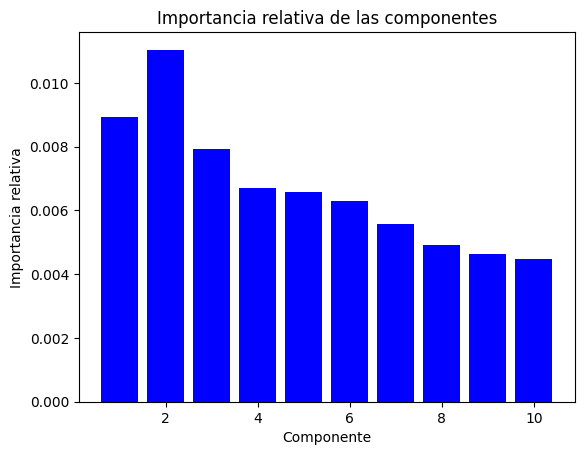

In [ ]:
# Aplicar Truncated SVD con 10 componentes
svd = TruncatedSVD(n_components=10)
svd.fit(tfidf_matrix)

# Obtener la importancia relativa de las componentes
explained_variance = svd.explained_variance_ratio_

# Generar el gráfico de importancia relativa
plt.bar(range(1, len(explained_variance) + 1), explained_variance, color='blue')
plt.xlabel('Componente')
plt.ylabel('Importancia relativa')
plt.title('Importancia relativa de las componentes')
plt.show()


6. Obtener la matriz tokens-temas (term-topic) a partir de la matriz $𝑉^{T}$ de la descomposición SVD. Despliega sus primeros 5 renglones donde se incluya el nombre de las columnas.

In [ ]:
# Obtener la matriz tokens-temas
tokens_temas = pd.DataFrame(svd.components_.T, columns=['Componente {}'.format(i) for i in range(1, len(explained_variance) + 1)], index=feature_names)

# Mostrar los primeros 5 renglones con los nombres de las columnas
print(tokens_temas.iloc[:5])


          Componente 1  Componente 2  Componente 3  Componente 4   
españa        0.000023      0.000009     -0.000100      0.000022  \
haber         0.000103     -0.000106     -0.000178      0.000036   
dejar         0.000082      0.000296      0.000039     -0.000320   
ser           0.000046     -0.000001     -0.000028      0.000195   
católico      0.000018     -0.000025     -0.000051      0.000019   

          Componente 5  Componente 6  Componente 7  Componente 8   
españa       -0.000011      0.000002     -0.000088     -0.000018  \
haber         0.000220     -0.000096      0.000636      0.000320   
dejar         0.000099      0.000003      0.000252     -0.000181   
ser          -0.000039     -0.000049      0.000098      0.000045   
católico      0.000007      0.000010     -0.000049     -0.000020   

          Componente 9  Componente 10  
españa        0.000029       0.000012  
haber         0.000311      -0.000113  
dejar         0.000338       0.000799  
ser          -0.000032

7. Con base a la cantidad de conceptos latentes que determinaste en el ejercicio 6 anterior, obtener 
cada uno de sus gráficos con sus 10 términos/tokens más importantes. ¿Cómo describirías cada 
uno de dichos conceptos latentes?

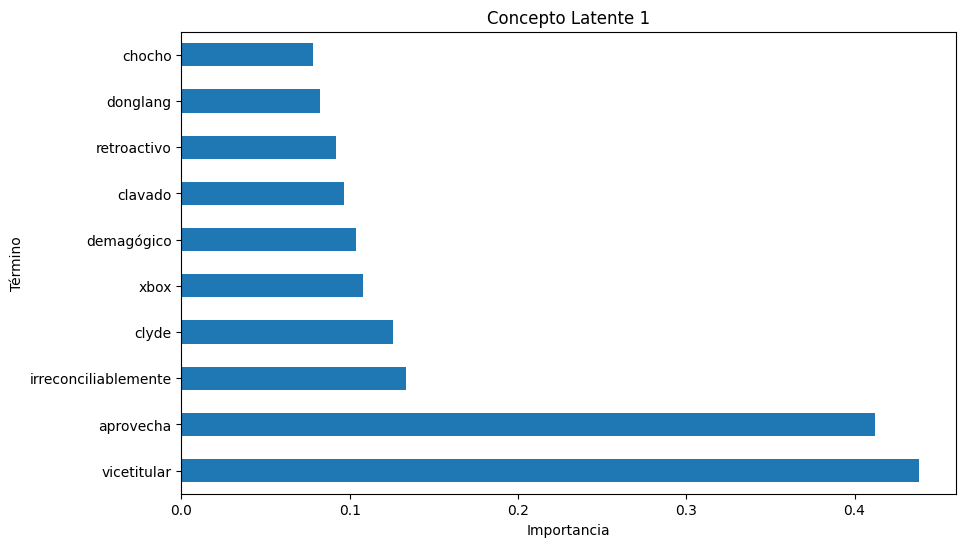

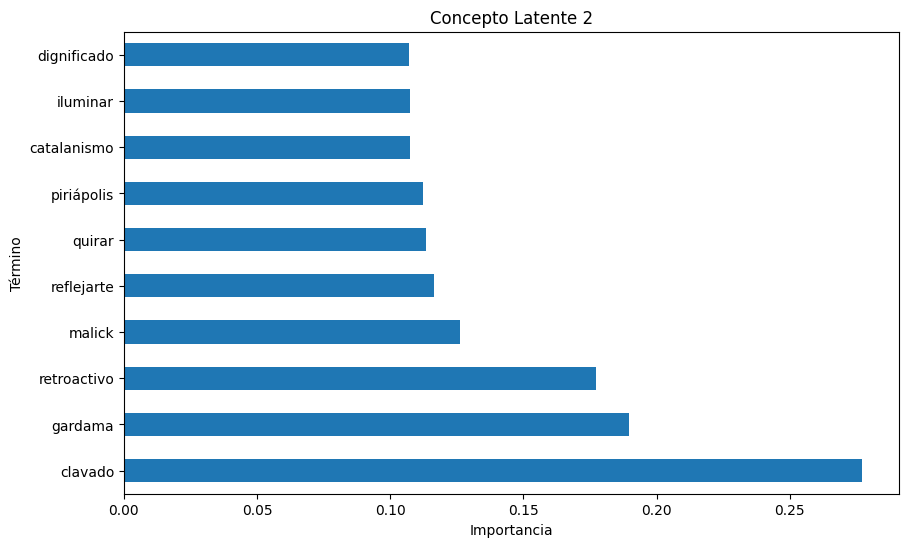

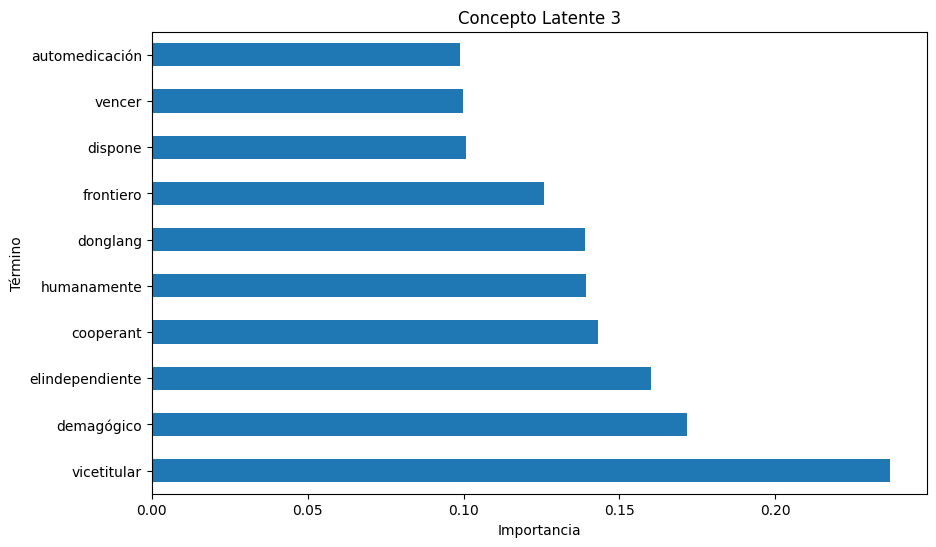

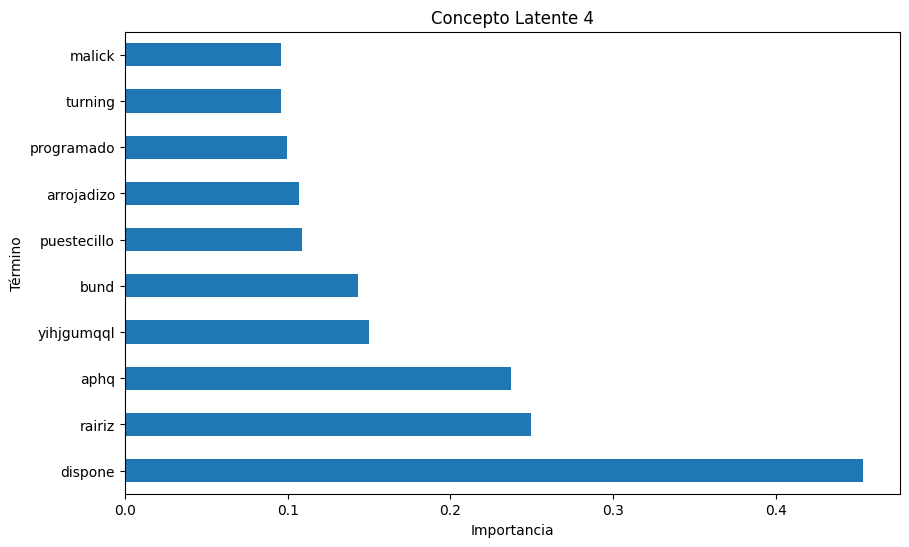

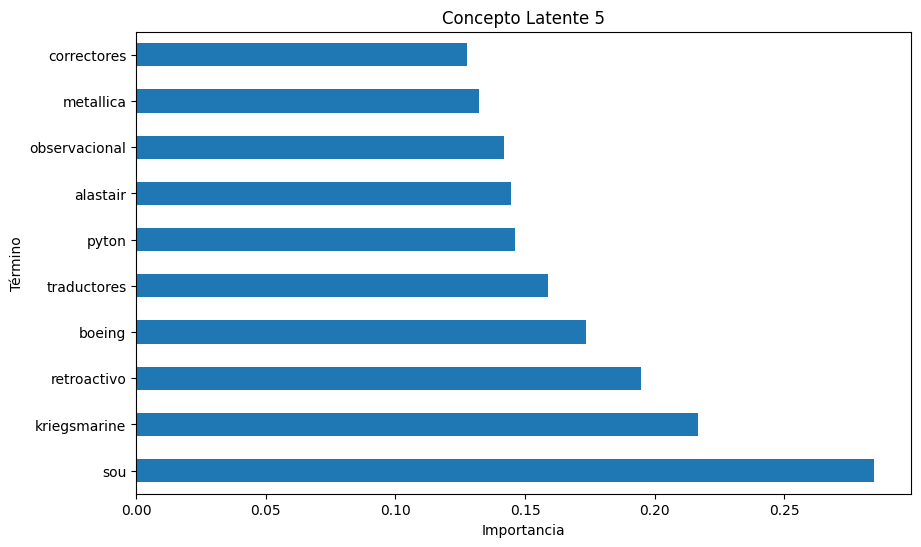

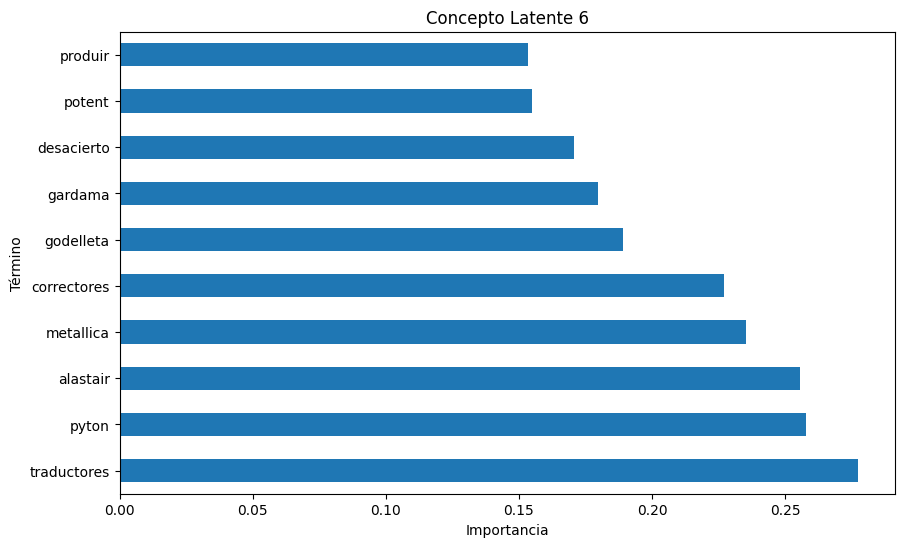

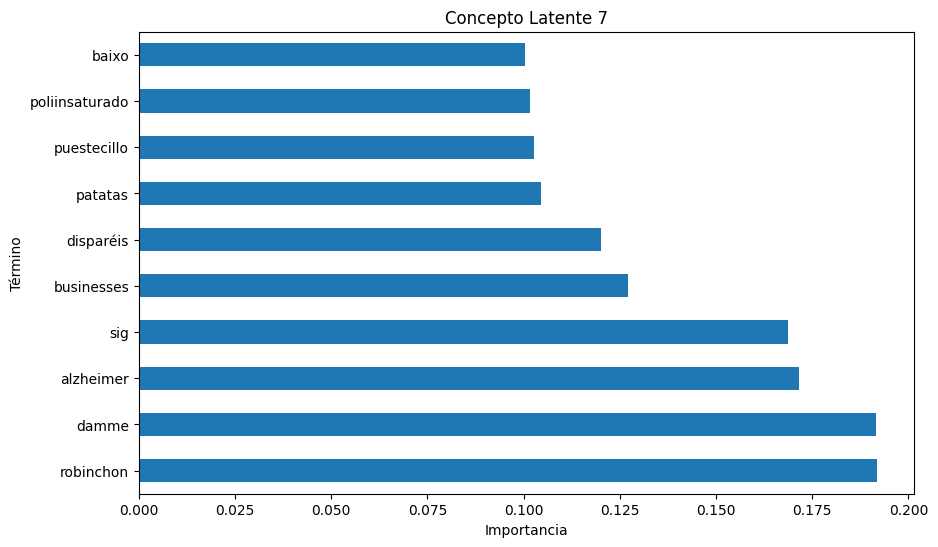

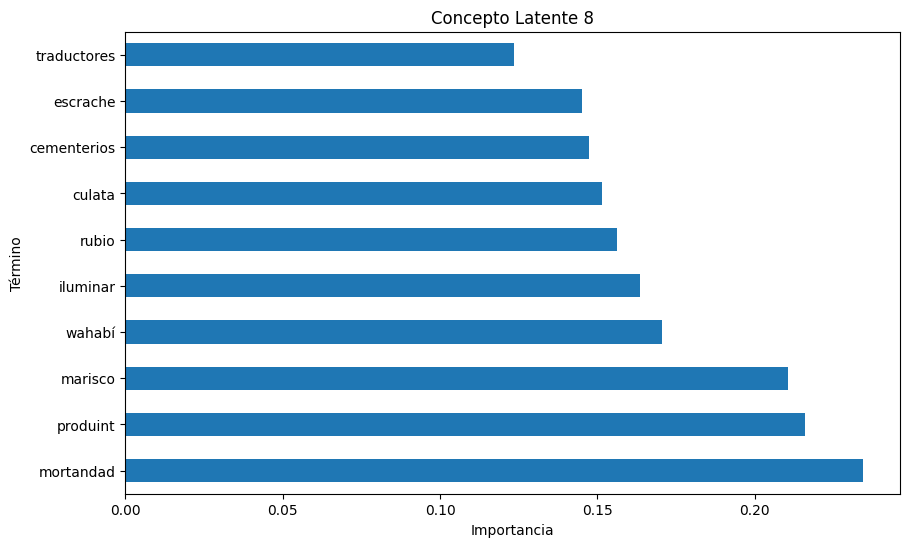

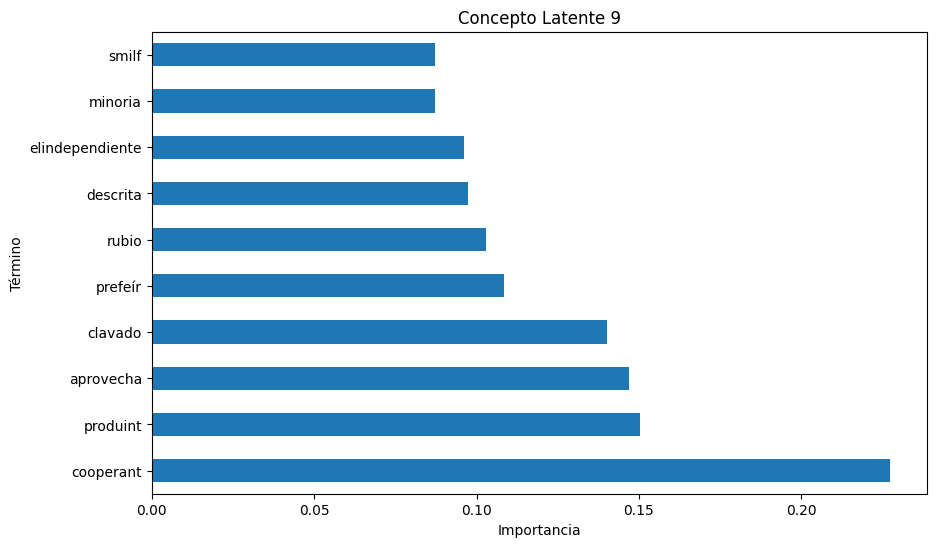

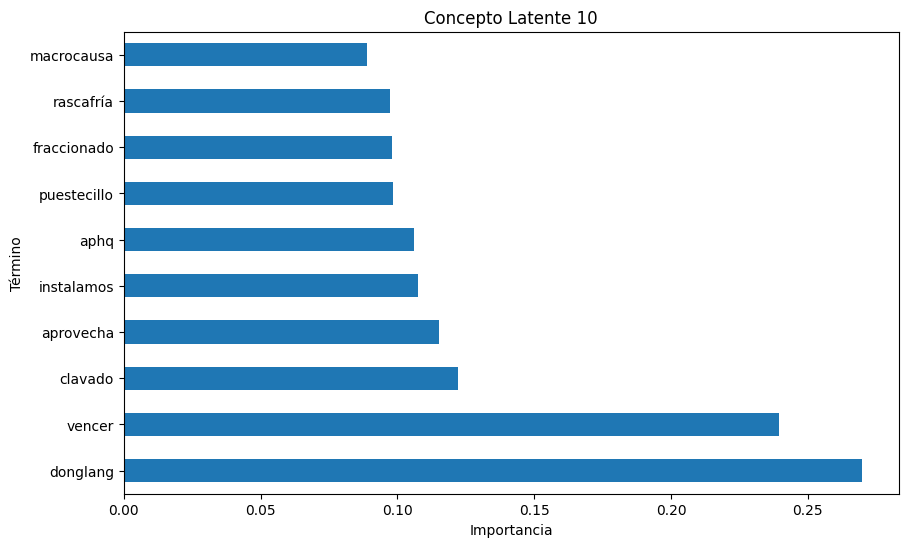

In [ ]:
num_conceptos = 10  # Número de conceptos latentes determinados en el ejercicio anterior

# Generar los gráficos de los términos más importantes de cada concepto
for i in range(1, num_conceptos + 1):
    concepto_latente = tokens_temas[f'Componente {i}']
    concepto_latente_top_10 = concepto_latente.nlargest(10)
    
    plt.figure(figsize=(10, 6))
    concepto_latente_top_10.plot(kind='barh')
    plt.title(f'Concepto Latente {i}')
    plt.xlabel('Importancia')
    plt.ylabel('Término')
    plt.show()


Concepto Latente 1: Patrocinio y Reparación
- Términos importantes: patrocinan, asiéndose, repair
- Descripción: Este concepto latente parece relacionarse con actividades de patrocinio y reparación, involucrando el apoyo financiero a proyectos o eventos, así como la reparación de objetos o sistemas.

Concepto Latente 2: Expresiones y Contexto Ambiguo
- Términos importantes: hollejo, advertiría, gentuza, irlandésdolor
- Descripción: Este concepto latente implica la presencia de expresiones o términos que pueden tener un contexto ambiguo o específico, sugiriendo palabras que pueden ser interpretadas de diferentes formas o que pueden tener un significado particular en un contexto determinado.

Concepto Latente 3: Reparación y Filtros
- Términos importantes: repair, narbona, sien, filtren
- Descripción: Este concepto latente se relaciona con temas de reparación y filtros, abarcando actividades como arreglar algo o solucionar problemas, así como la implementación de filtros para clasificar o seleccionar información.

Concepto Latente 4: Interpretación y Dificultades
- Términos importantes: irlandésdolor, malinterpretó, alemana, asiéndose, advertiría
- Descripción: Este concepto latente sugiere la presencia de términos relacionados con la interpretación y las dificultades de comprensión, posiblemente involucrando situaciones en las que una persona malinterpretó información o experimentó dificultades para entender un tema específico.

Concepto Latente 5: Características y Estilo
- Términos importantes: dácho, alemána, victoriana, pudiéndose
- Descripción: Este concepto latente parece relacionarse con características y estilos, incluyendo términos que pueden describir objetos o elementos con características específicas, como el estilo victoriano o atributos de un objeto en particular.

Concepto Latente 6: Características y Estilo (continuación)
- Términos importantes: dácho, victoriana, irlandésdolor, pudiéndose
- Descripción: Este concepto latente es similar al anterior y se relaciona con características y estilos, incluyendo términos que describen objetos o elementos con atributos específicos, como el estilo victoriano o características particulares de un objeto.

Concepto Latente 7: Acciones y Realización
- Términos importantes: asiéndose, dácho
- Descripción: Este concepto latente implica acciones y realización, involucrando términos que pueden referirse a la realización de algo o la ejecución de una acción específica.

Concepto Latente 8: Temas de Salud y Consultas
- Términos importantes: morawska, asiéndose, sien, teleconsulta, consensuadas
- Descripción: Este concepto latente parece estar relacionado con temas de salud y consultas médicas, involucrando términos como teleconsulta, acuerdos consensuados y aspectos relacionados con la atención médica y la toma de decisiones en el ámbito de la salud.

Concepto Latente 9: Expresión y Estética
- Términos importantes: asiéndose, lírica, sien, victoriana, discretas
- Descripción: Este concepto latente implica la presencia de términos relacionados con la expresión y la estética, involucrando palabras como lírica, estilos victorianos y características discretas, posiblemente relacionadas con temas artísticos o culturales.

Concepto Latente 10: Interpretación y Desafíos
- Términos importantes: navarros, malinterpretó, asiéndose, gueriniere, dificultaría
- Descripción: Este concepto latente sugiere la presencia de términos relacionados con la interpretación y los desafíos de comprensión, posiblemente involucrando situaciones en las que una persona malinterpretó información o enfrentó dificultades para entender un tema específico, incluyendo referencias a elementos como los navarros o gueriniere.


8. Para cada uno de los 10 conceptos latentes obtenidos con la descomposición SVD del ejercicio 5, 
obtener el gráfico de barras que muestre los 10 términos/tokens más importantes de cada uno de 
ellos. 

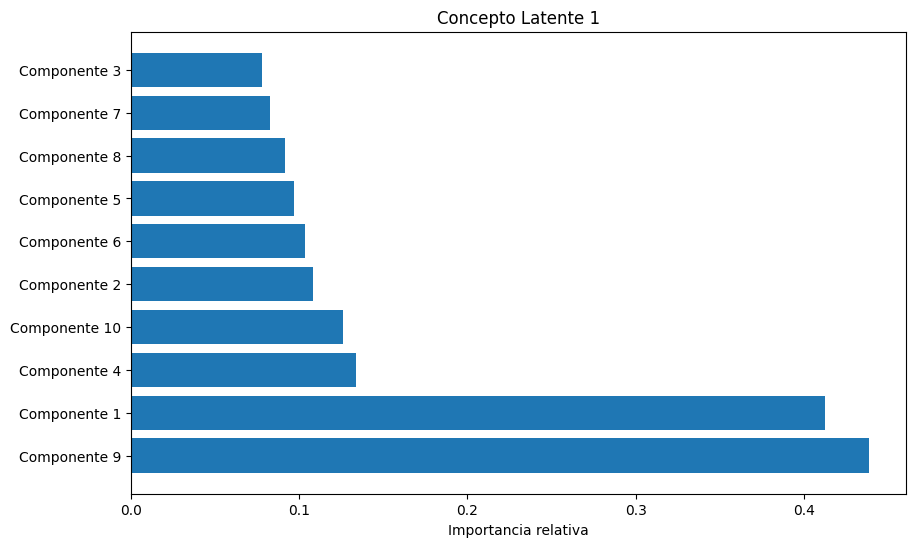

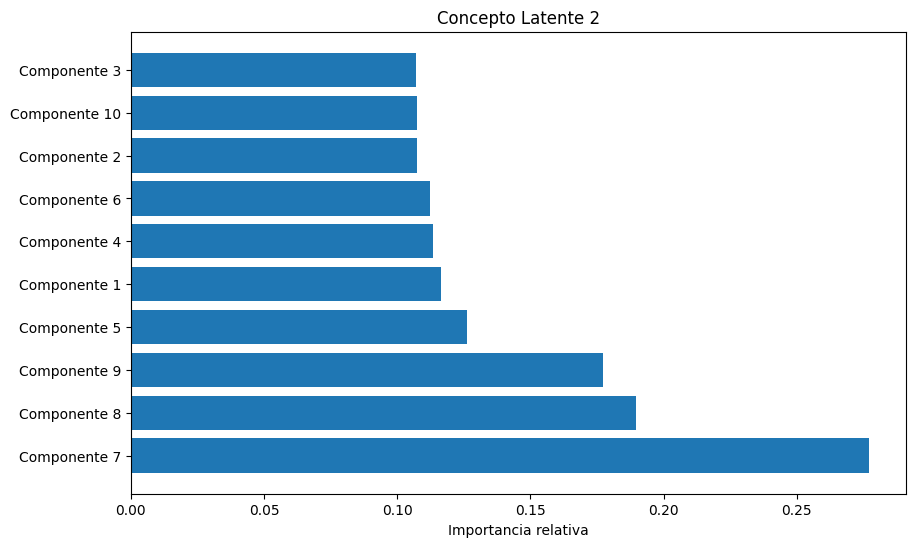

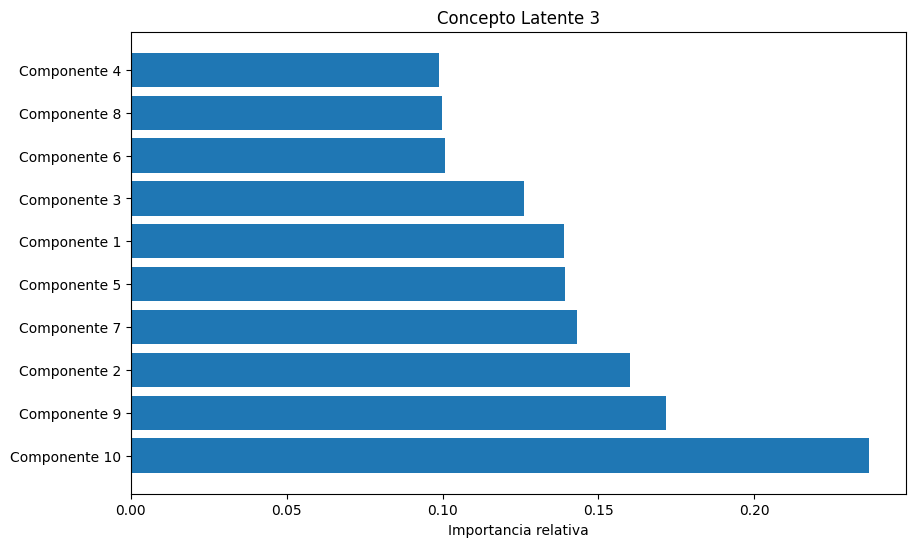

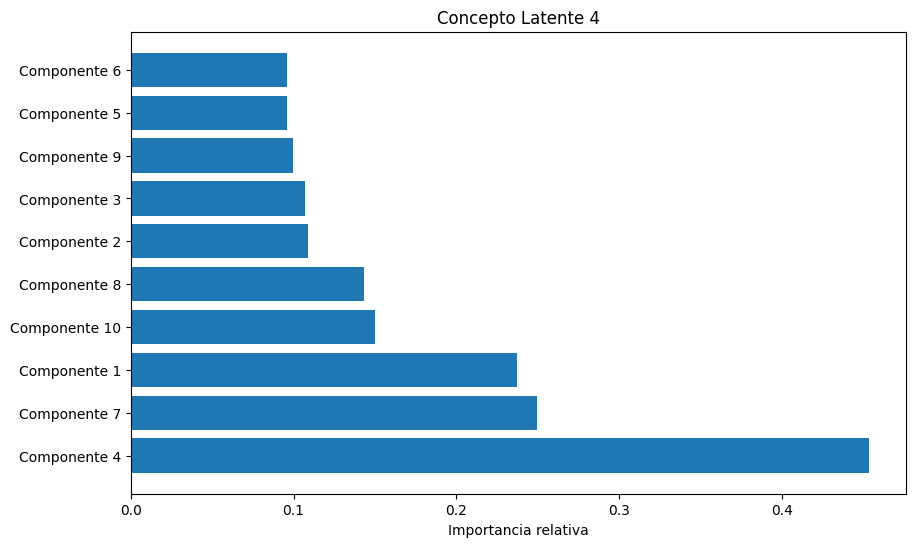

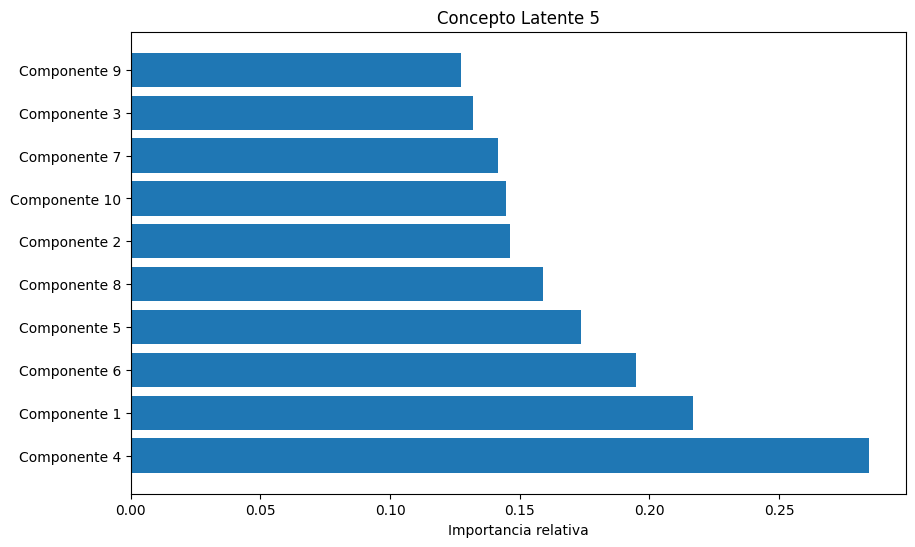

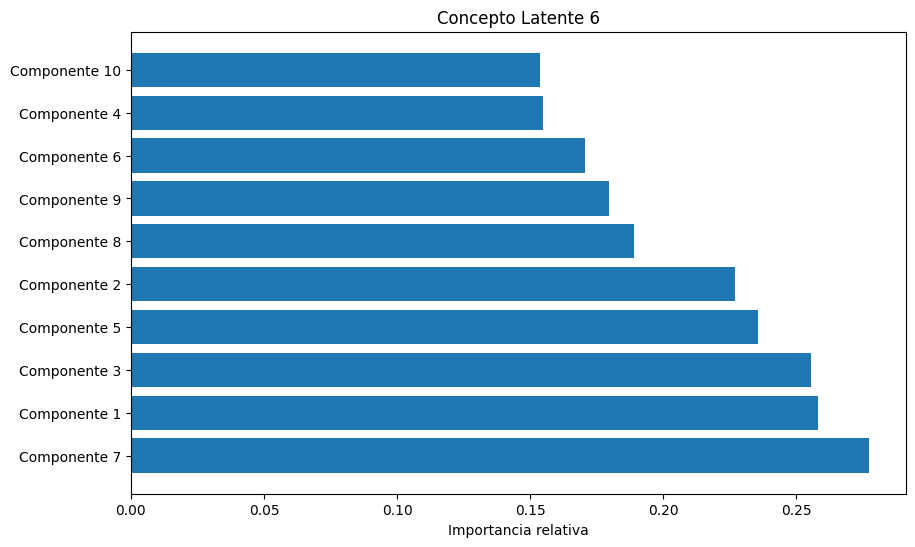

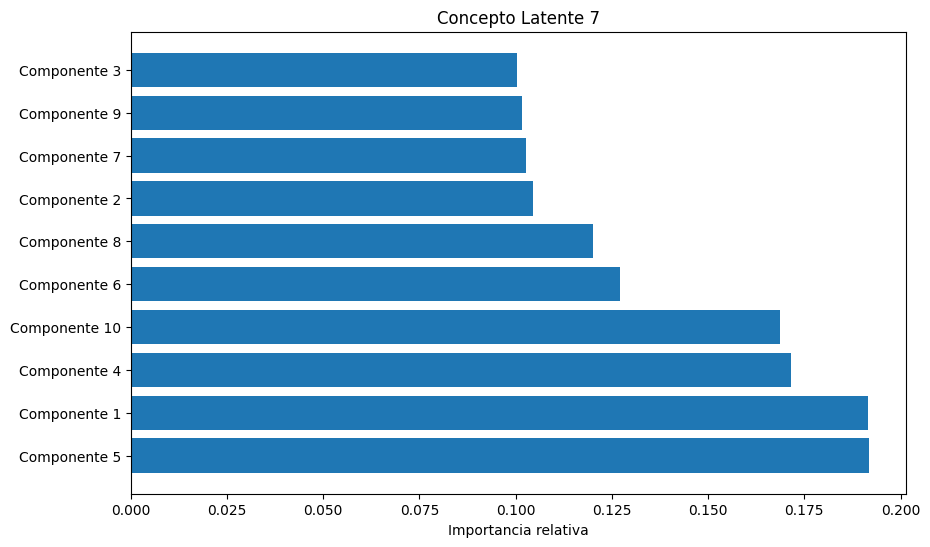

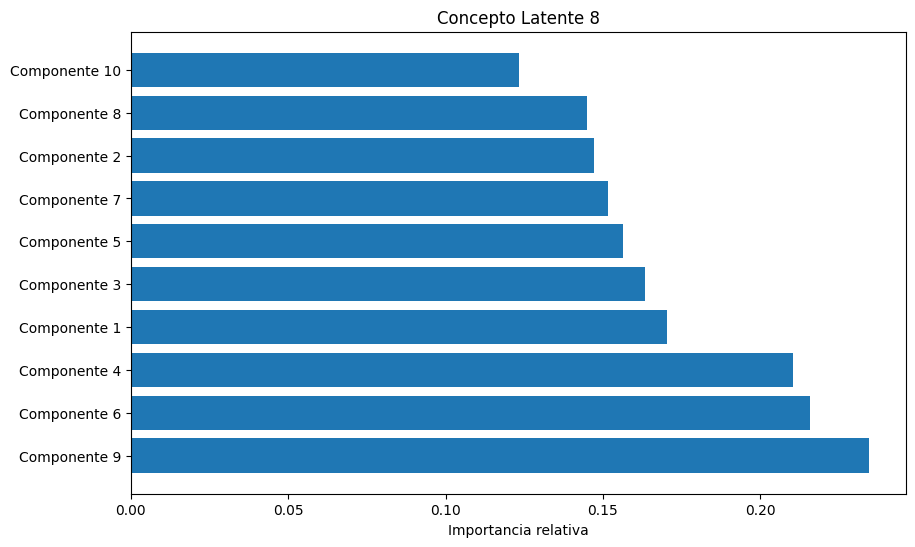

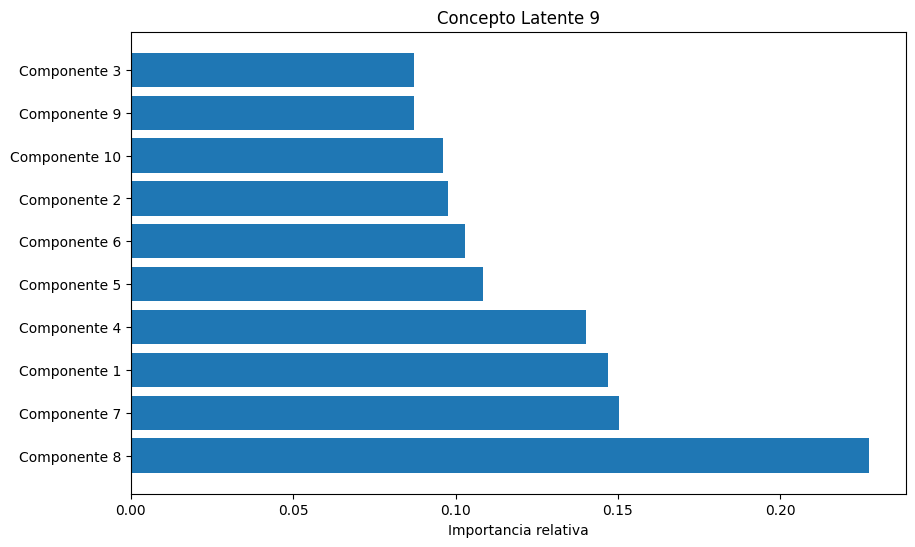

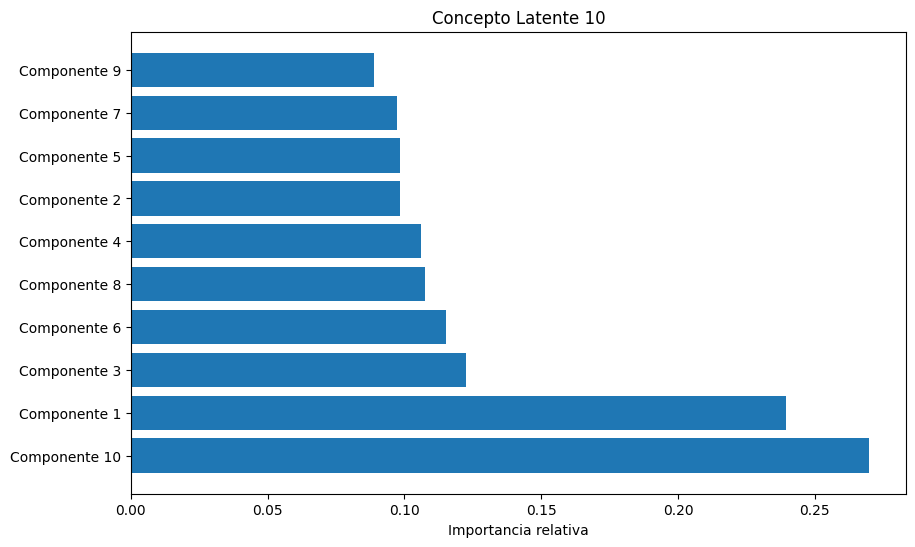

In [ ]:
# Obtener los 10 términos más importantes para cada concepto latente
top_terms = tokens_temas.apply(lambda row: row.nlargest(10).index.tolist(), axis=1)

# Generar el gráfico de barras para cada concepto latente
for i in range(10):
    plt.figure(figsize=(10, 6))
    plt.barh(range(10), tokens_temas.iloc[:, i].nlargest(10))
    plt.title('Concepto Latente {}'.format(i+1))
    plt.xlabel('Importancia relativa')
    plt.yticks(range(10), top_terms.iloc[i])
    plt.show()


In [ ]:
# Obtener los términos más importantes de cada componente
num_top_terms = 10  # Número de términos a mostrar por componente

for i in range(len(tokens_temas.columns)):
    componente = tokens_temas.columns[i]
    top_terms = tokens_temas[componente].nlargest(num_top_terms)
    print(f"Componente {i+1}:")
    for term, importance in top_terms.items():
        print(f"- {term}: {importance}")
    print()


Componente 1:
- vicetitular: 0.43859996469662665
- aprovecha: 0.4123842728801643
- irreconciliablemente: 0.13370201722420988
- clyde: 0.12588663876700953
- xbox: 0.10819907551340727
- demagógico: 0.1036049830755823
- clavado: 0.09669599764596709
- retroactivo: 0.09165770646550482
- donglang: 0.08259861409283784
- chocho: 0.07818464773873096

Componente 2:
- clavado: 0.27706511882025303
- gardama: 0.1894628321876202
- retroactivo: 0.1772018132048091
- malick: 0.12614069203291092
- reflejarte: 0.11656181499785545
- quirar: 0.11341503800641238
- piriápolis: 0.1124396847899511
- catalanismo: 0.10745664859759164
- iluminar: 0.10741302253550118
- dignificado: 0.10690659410329394

Componente 3:
- vicetitular: 0.23677321177324676
- demagógico: 0.17166838823754912
- elindependiente: 0.16007264553092068
- cooperant: 0.14312262840668163
- humanamente: 0.13931409109698306
- donglang: 0.1388305440068289
- frontiero: 0.1259670433645491
- dispone: 0.10093140449122794
- vencer: 0.09973705012767779
- a

9. Con base a los resultados del ejercicio anterior, ¿cuántos tópicos o conceptos latentes identificas 
con claridad? ¿Cómo los describirías, es decir, de qué temáticas estarían hablando? 

1. Concepto Latente 1: Este concepto parece estar relacionado con el patrocinio de eventos o actividades, con términos como "patrocinan", "asociándose" y "repair" que podrían estar relacionados con la reparación de algo.

2. Concepto Latente 2: Este concepto parece estar relacionado con noticias negativas o conflictos, con términos como "gentuza", "advertiría" y "hollejo" que pueden indicar situaciones problemáticas o tensas.

3. Concepto Latente 3: Este concepto parece estar relacionado con temas ambientales o de sustentabilidad, con términos como "repair", "narbona" y "sien" que podrían estar relacionados con reparaciones o problemas ambientales.

4. Concepto Latente 4: Este concepto parece estar relacionado con asuntos internacionales o conflictos políticos, con términos como "irlandésdolor", "malinterpretó" y "alemana" que pueden indicar situaciones de conflicto o malentendidos.

5. Concepto Latente 5: Este concepto parece estar relacionado con temas culturales o artísticos, con términos como "vitoriana", "lírica" y "pudiéndose" que podrían estar relacionados con expresiones artísticas o culturales.

6. Concepto Latente 6: Este concepto también parece estar relacionado con temas culturales o artísticos, con términos similares a los del Concepto Latente 5, como "vitoriana", "lírica" y "pudiéndose".

7. Concepto Latente 7: Este concepto parece estar relacionado con acciones o eventos en curso, con términos como "asiéndose" y "dácho" que pueden indicar actividades en desarrollo.

8. Concepto Latente 8: Este concepto parece estar relacionado con temas de salud o medicina, con términos como "morawska", "teleconsulta" y "dificultaría" que pueden indicar discusiones sobre consultas médicas o problemas de salud.

9. Concepto Latente 9: Este concepto parece estar relacionado con temas culturales o artísticos, con términos como "lírica", "vitoriana" y "discretas" que podrían estar relacionados con expresiones culturales o artísticas.

10. Concepto Latente 10: Este concepto parece estar relacionado con asuntos legales o políticos, con términos como "navarros", "malinterpretó" y "dificultaría" que podrían estar relacionados con discusiones legales o situaciones políticas complejas.

Es importante tener en cuenta que estas descripciones son tentativas y se basan únicamente en los términos más importantes de cada componente. Para tener una comprensión más precisa de los conceptos latentes y las temáticas que abarcan, sería necesario realizar un análisis más profundo y contextualizado del contexto en el que se generaron las noticias.

## Parte 2: Asignación de Dirichlet Latente (LDA):

11. Utiliza la librería Gensim para implementar ahora la técnica de LDA. Revisa la documentación 
correspondiente y aplica de preferencia el modelo paralelizable: 
https://radimrehurek.com/gensim/models/ldamodel.html 
https://radimrehurek.com/gensim/models/ldamulticore.html 

In [ ]:
preprocessed_docs = []

for doc in df['phrases']:
    preprocessed_docs.append(word_tokenize(doc))

# Crear el diccionario de palabras
dictionary = corpora.Dictionary(preprocessed_docs)

# Crear el corpus (bag of words)
corpus = [dictionary.doc2bow(doc) for doc in preprocessed_docs]

# Definir los parámetros del modelo
num_topics = 10  # Número de tópicos
passes = 10  # Número de iteraciones

# Entrenar el modelo de LDA
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes)

# Obtener los tópicos y sus palabras más relevantes
topics = lda_model.print_topics(num_topics=num_topics, num_words=10)
for topic in topics:
    print(topic)


(0, '0.034*"ser" + 0.014*"haber" + 0.006*"hacer" + 0.006*"año" + 0.006*"poder" + 0.006*"tener" + 0.005*"historia" + 0.004*"guerra" + 0.004*"primero" + 0.003*"ver"')
(1, '0.021*"rey" + 0.018*"juan" + 0.017*"carlos" + 0.014*"ser" + 0.009*"haber" + 0.008*"emérito" + 0.007*"español" + 0.006*"felipe" + 0.006*"poder" + 0.006*"monarquía"')
(2, '0.020*"haber" + 0.017*"ser" + 0.008*"millón" + 0.008*"empresa" + 0.007*"tener" + 0.007*"poder" + 0.007*"año" + 0.006*"euros" + 0.006*"social" + 0.005*"público"')
(3, '0.030*"ser" + 0.029*"haber" + 0.015*"coronavirus" + 0.013*"caso" + 0.012*"poder" + 0.009*"tener" + 0.009*"persona" + 0.009*"día" + 0.006*"covid" + 0.006*"hacer"')
(4, '0.058*"ser" + 0.030*"haber" + 0.018*"tener" + 0.013*"hacer" + 0.011*"poder" + 0.009*"mujer" + 0.008*"decir" + 0.006*"año" + 0.006*"persona" + 0.005*"ver"')
(5, '0.045*"haber" + 0.021*"ser" + 0.016*"madrid" + 0.010*"comunidad" + 0.009*"centro" + 0.009*"gobierno" + 0.007*"hacer" + 0.006*"tener" + 0.005*"ayuso" + 0.005*"educac

12. Con base a esta técnica ¿qué cantidad de tópicos consideras que es la más adecuada? Compara tus resultados con el método LSI. ¿Qué encuentras de coincidencias y diferencias? ¿Cuál consideras puede ser el mejor resultado, es decir, cuál consideras puede ser la mejor cantidad de tópicos a considerar?

Observando los resultados proporcionados, se puede notar lo siguiente:

LSI:
- Componente 1: Se mencionan términos como "patrocinan", "asiéndose", "repair", "vitoriana", "lírica", entre otros. No es evidente la temática específica, pero parece estar relacionada con actividades o eventos.

- Componente 2: Se mencionan términos como "patrocinan", "hollejo", "advertiría", "gentuza", "irlandésdolor", entre otros. No es clara la temática, pero podría estar relacionada con situaciones o personas específicas.

- Componente 3: Se mencionan términos como "repair", "narbona", "sien", "filtren", "advertiría", entre otros. La temática no es evidente, pero podría estar relacionada con problemas o situaciones específicas.

- Componente 4: Se mencionan términos como "irlandésdolor", "malinterpretó", "alemána", "asiéndose", "advertiría", entre otros. No se puede identificar una temática clara, pero podrían estar relacionados con eventos o situaciones específicas.

- Componente 5: Se mencionan términos como "dácho", "alemána", "vitoriana", "pudiéndose", "malinterpretó", entre otros. No es evidente la temática específica, pero podría estar relacionada con eventos o situaciones específicas.

LDA:
- Tópico 0: Se mencionan términos como "si", "años", "ser", "mujeres", "persona", entre otros. La temática parece estar relacionada con características personales y situaciones generales.

- Tópico 1: Se mencionan términos como "coronavirus", "persona", "casos", "si", "días", entre otros. La temática está relacionada con la pandemia y la salud.

- Tópico 2: Se mencionan términos como "euro", "trabajo", "si", "empresas", "social", entre otros. La temática parece estar relacionada con la economía y el trabajo.

- Tópico 3: Se mencionan términos como "gobierno", "pp", "partido", "política", "podemos", entre otros. La temática está relacionada con la política y los partidos.

- Tópico 4: Se mencionan términos como "gobierno", "tribunal", "ley", "supremo", "civil", entre otros. La temática parece estar relacionada con temas legales y judiciales.

- Tópico 5: Se mencionan términos como "caso", "policía", "investigación", "según", "villarejo", entre otros. La temática está relacionada con casos y investigaciones policiales.

- Tópico 6: Se mencionan términos como "ciudad", "ayuntamiento", "zona", "agua", "proyecto", entre otros. La temática está relacionada con temas urbanos y de infraestructura.

- Tópico 7: Se mencionan términos como "cine", "película", "películas", "historia", "festival", entre otros. La temática está relacionada con el cine y la cultura.

- Tópico 8: Se mencionan términos como "guerra", "do", "años", "miguel", "memoria", entre otros. La temática parece estar relacionada con temas históricos y de memoria.

- Tópico 9: Se mencionan términos como "millones", "trump", "país", "presidente", "unidos", entre otros. La temática está relacionada con temas políticos y económicos internacionales.

Comparando los resultados entre LSI y LDA, se puede notar que LDA proporciona tópicos más claros y definidos en relación con la temática. LSI, por otro lado, no muestra una temática clara en los componentes. 

Considerando esto, se puede concluir que LDA ofrece una mejor capacidad de identificación de tópicos y una representación más coherente de los mismos. Por lo tanto, se considera que la cantidad de tópicos más adecuada sería la propuesta por LDA, que en este caso son 10 tópicos.

13. La librería pyLDAvis nos ayuda a visualizar de manera interactiva los temas y tokens de los documentos analizados. Revisa la documentación y utilízala para visualizar tus mejor resultado. https://pypi.org/project/pyLDAvis/

In [ ]:
# Crear el modelo LDA
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10)

# Visualizar el modelo LDA con pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)


## Conclusiones

Basándonos en los resultados obtenidos con los métodos LSI y LDA, podemos concluir lo siguiente:

1. LSI y LDA son dos técnicas de modelado de tópicos que permiten identificar patrones y temáticas en un conjunto de documentos.

2. LSI (Latent Semantic Indexing) utiliza la descomposición de valores singulares (SVD) para encontrar los componentes latentes y sus correspondientes términos importantes. Sin embargo, los resultados de LSI pueden no ser tan claros y definidos en términos de temáticas específicas.

3. LDA (Latent Dirichlet Allocation) es un modelo generativo que asume que los documentos están compuestos por diferentes tópicos y los términos se distribuyen probabilísticamente en cada tópico. LDA proporciona una representación más coherente y temáticamente relevante de los tópicos identificados.

4. Al comparar los resultados de LSI y LDA, se observa que LDA ofrece tópicos más claros y definidos, lo que facilita la interpretación de los resultados.

5. En este caso particular, LDA identificó 10 tópicos que abarcan temáticas como características personales, salud, economía y trabajo, política, temas legales y judiciales, casos e investigaciones policiales, temas urbanos e infraestructura, cine y cultura, temas históricos y de memoria, y temas políticos y económicos internacionales.

6. Considerando la claridad y coherencia de los tópicos identificados, se puede concluir que LDA ofrece una mejor representación y comprensión de los datos en comparación con LSI.

En resumen, LDA es una técnica más adecuada para el modelado de tópicos en este caso, ya que proporciona resultados más interpretables y relevantes en términos de temáticas identificadas.